In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-hdf5/merged.hdf5


In [2]:
if not os.path.exists('/kaggle/working/prescription-resnet50-bilstm'):
    ! git clone https://github.com/aritra-github26/prescription-resnet50-bilstm.git

Cloning into 'prescription-resnet50-bilstm'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 40 (delta 3), reused 39 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 77.99 KiB | 7.09 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
os.chdir('/kaggle/working/prescription-resnet50-bilstm')
! pwd

/kaggle/working/prescription-resnet50-bilstm


In [4]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [5]:
os.chdir('/kaggle/working/prescription-resnet50-bilstm/src')
! pwd

/kaggle/working/prescription-resnet50-bilstm/src


In [6]:
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet18
from torch.autograd import Variable
import torchvision
from data import preproc as pp
from data import evaluation
from torch.utils.data import Dataset
import time
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=8192):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
            
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        if x.size(-1) != self.d_model:
            raise ValueError(f'Expected features of size {self.d_model}, got {x.size(-1)}')
        return self.dropout(x + self.pe[:, :x.size(1)])



In [8]:
class ImprovedOCR(nn.Module):
    def __init__(self, vocab_len, hidden_dim):
        super().__init__()

        # Create ResNet-18 backbone with modified stride
        self.backbone = resnet18()
        # Modify first conv layer to preserve spatial information
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=(2, 1), padding=3, bias=False)
        # Modify maxpool to preserve horizontal info
        self.backbone.maxpool = nn.MaxPool2d(kernel_size=3, stride=(2, 1), padding=1)
        del self.backbone.fc
        
        # Feature refinement
        self.conv = nn.Sequential(
            nn.Conv2d(512, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2)
        )
        
        # Adaptive average pooling for height dimension
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        
        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=True,
            dropout=0.5,
            batch_first=True
        )
        
        # Layer normalization for sequence modeling
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        
        # Prediction head
        self.vocab = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, vocab_len)
        )
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout=0.1)
        
    def forward(self, x):
        # Extract features (B, C, H, W)
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        # Refine features
        x = self.conv(x)  # (B, hidden_dim, H, W)
        
        # Reduce height dimension using adaptive pooling
        x = self.adaptive_pool(x)  # (B, hidden_dim, 1, W)
        x = x.squeeze(2)  # (B, hidden_dim, W)
        
        # Convert to sequence format
        x = x.permute(0, 2, 1)  # (B, W, hidden_dim)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # LSTM sequence modeling
        x, _ = self.lstm(x)  # (B, W, hidden_dim*2)
        
        # Normalize sequence
        x = self.layer_norm(x)
        
        # Generate predictions
        x = self.vocab(x)  # (B, W, vocab_len)
        
        # Convert to (W, B, vocab_len) for CTC
        x = x.permute(1, 0, 2)
        
        return x

def make_model(vocab_len, hidden_dim=256):
    return ImprovedOCR(vocab_len, hidden_dim)


In [9]:
"""
Uses generator functions to supply train/test with data.
Image renderings and text are created on the fly each time.
"""

class DataGenerator(Dataset):
    """Generator class with data streaming"""

    def __init__(self, source,charset, max_text_length, split, transform):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.transform = transform
        
        self.split = split
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            self.dataset[self.split] = dict()

            self.dataset[self.split]['dt'] = np.array(f[self.split]['dt'])
            self.dataset[self.split]['gt'] = np.array(f[self.split]['gt'])
          
            randomize = np.arange(len(self.dataset[self.split]['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset[self.split]['dt'] = self.dataset[self.split]['dt'][randomize]
            self.dataset[self.split]['gt'] = self.dataset[self.split]['gt'][randomize]

            # decode sentences from byte
            self.dataset[self.split]['gt'] = [x.decode() for x in self.dataset[self.split]['gt']]
            
        self.size = len(self.dataset[self.split]['gt'])


    def __getitem__(self, i):
        img = self.dataset[self.split]['dt'][i]
        
        #making image compatible with resnet
        img = np.repeat(img[..., np.newaxis],3, -1)    
        img = pp.normalization(img)
        
        if self.transform is not None:
            img = self.transform(img)

        y_train = self.tokenizer.encode(self.dataset[self.split]['gt'][i]) 
        
        #padding till max length
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt          

    def __len__(self):
      return self.size



class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""

        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""
        
        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = pp.text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")



In [10]:
import os
import datetime
import string

batch_size = 16
epochs = 200

# define paths
#change paths accordingly

source_path = '/kaggle/input/data-hdf5/merged.hdf5'
output_path = '/kaggle/working/output'
target_path = output_path + '/merged_training_weights.pt'

os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output:", output_path)
print("target", target_path)
print("charset:", charset_base)

source: /kaggle/input/data-hdf5/merged.hdf5
output: /kaggle/working/output
target /kaggle/working/output/merged_training_weights.pt
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [11]:
import torchvision.transforms as T

device = torch.device("cuda")
transform = T.Compose([
    T.ToTensor()])
tokenizer = Tokenizer(charset_base)

In [12]:
import os
os.path.isdir('/kaggle/input/data-hdf5')

True

In [13]:


train_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'train',transform), batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'valid',transform), batch_size=batch_size, shuffle=False, num_workers=2)


In [14]:
model = make_model(vocab_len=tokenizer.vocab_size)
_=model.to(device)

In [15]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
criterion.to(device)
lr = .001 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)


In [ ]:

def train(model, criterion, optimizer, scheduler, dataloader, vocab_length, device, grad_clip=1.0):
    """
    Train the model using the provided dataloader, optimized for ResNet18.
    
    Args:
        model: The OCR model
        criterion: Loss function (CTC)
        optimizer: Optimizer instance
        scheduler: Learning rate scheduler
        dataloader: Training data loader
        vocab_length: Size of vocabulary
        device: Device to train on
        grad_clip: Gradient clipping value (default: 1.0)
        
    Returns:
        float: Average loss for the epoch
    """
    model.train()
    total_loss = 0
    total_items = 0
    
    for batch, (imgs, labels_y,) in enumerate(dataloader):
        imgs = imgs.to(device)
        labels_y = labels_y.to(device)
        batch_size = imgs.size(0)
        
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Forward pass (keeping in full precision since CTC doesn't support half precision)
        output = model(imgs.float())
        
        # Ensure output is in (batch, seq_len, vocab_size) format
        if output.dim() != 3:
            raise ValueError(f"Expected 3D output tensor, got shape: {output.shape}")
        
        # Permute to (seq_len, batch, vocab_size) for CTC loss
        log_probs = F.log_softmax(output, dim=2).permute(1, 0, 2)
        
        # Calculate input sequence lengths (all are same length after CNN processing)
        input_lengths = torch.full((batch_size,), 
                                 log_probs.size(0), 
                                 dtype=torch.long,
                                 device=device)
        
        # Calculate target lengths (excluding padding)
        target_lengths = []
        labels_list = []
        valid_samples = []
        
        # Process each sequence in the batch
        for i in range(batch_size):
            # Find non-zero elements (non-padding)
            non_zero = labels_y[i].nonzero().squeeze()
            if non_zero.dim() == 0:  # Handle case of empty sequence
                continue  # Skip this sample
            
            length = non_zero.shape[0]
            if length > log_probs.size(0):  # Skip if target is longer than output
                continue
                
            sequence = labels_y[i, :length]
            target_lengths.append(length)
            labels_list.append(sequence)
            valid_samples.append(i)
        
        # Skip batch if no valid samples
        if not valid_samples:
            continue
            
        # Keep only valid samples
        valid_samples = torch.tensor(valid_samples, device=device)
        log_probs = log_probs[:, valid_samples, :]
        input_lengths = input_lengths[valid_samples]
        
        # Convert target lengths to tensor
        target_lengths = torch.tensor(target_lengths, dtype=torch.long, device=device)
        
        # Concatenate all label sequences
        labels_packed = torch.cat(labels_list)
        
        # CTC loss calculation
        try:
            loss = criterion(log_probs,  # (T, N, C)
                           labels_packed,  # Flattened target sequences
                           input_lengths,  # Length of each input sequence (N,)
                           target_lengths)  # Length of each target sequence (N,)
            
            loss.backward()
            
            # Gradient clipping to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += loss.item() * len(valid_samples)
            total_items += len(valid_samples)
            
        except RuntimeError as e:
            print(f"Error in batch {batch}:")
            print(f"log_probs shape: {log_probs.shape}")
            print(f"labels_packed shape: {labels_packed.shape}")
            print(f"input_lengths shape: {input_lengths.shape}")
            print(f"target_lengths shape: {target_lengths.shape}")
            raise e
    
    return total_loss / total_items if total_items > 0 else float('inf')


def evaluate(model, criterion, dataloader, vocab_length, device):
    """
    Evaluate the model using the provided dataloader.
    
    Args:
        model: The OCR model
        criterion: Loss function (CTC)
        dataloader: Validation data loader
        vocab_length: Size of vocabulary
        device: Device to evaluate on
        
    Returns:
        float: Average loss for the epoch
    """
    model.eval()
    total_loss = 0
    total_items = 0

    with torch.no_grad():
        for batch, (imgs, labels_y) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels_y = labels_y.to(device)
            batch_size = imgs.size(0)

            # Forward pass
            output = model(imgs.float())
            
            # Ensure output is in (batch, seq_len, vocab_size) format
            if output.dim() != 3:
                raise ValueError(f"Expected 3D output tensor, got shape: {output.shape}")
            
            # Permute to (seq_len, batch, vocab_size) for CTC loss
            log_probs = F.log_softmax(output, dim=2).permute(1, 0, 2)
            
            # Calculate input sequence lengths (all are same length after CNN processing)
            input_lengths = torch.full((batch_size,), 
                                     log_probs.size(0), 
                                     dtype=torch.long,
                                     device=device)
            
            # Calculate target lengths (excluding padding)
            target_lengths = []
            labels_list = []
            valid_samples = []
            
            # Process each sequence in the batch
            for i in range(batch_size):
                # Find non-zero elements (non-padding)
                non_zero = labels_y[i].nonzero().squeeze()
                if non_zero.dim() == 0:  # Handle case of empty sequence
                    continue  # Skip this sample
                
                length = non_zero.shape[0]
                if length > log_probs.size(0):  # Skip if target is longer than output
                    continue
                    
                sequence = labels_y[i, :length]
                target_lengths.append(length)
                labels_list.append(sequence)
                valid_samples.append(i)
            
            # Skip batch if no valid samples
            if not valid_samples:
                continue
                
            # Keep only valid samples
            valid_samples = torch.tensor(valid_samples, device=device)
            log_probs = log_probs[:, valid_samples, :]
            input_lengths = input_lengths[valid_samples]
            
            # Convert target lengths to tensor
            target_lengths = torch.tensor(target_lengths, dtype=torch.long, device=device)
            
            # Concatenate all label sequences
            labels_packed = torch.cat(labels_list)
            
            try:
                # CTC loss calculation
                loss = criterion(log_probs,
                               labels_packed,
                               input_lengths,
                               target_lengths)
                
                total_loss += loss.item() * len(valid_samples)
                total_items += len(valid_samples)
                
            except RuntimeError as e:
                print(f"Error in batch {batch}:")
                print(f"log_probs shape: {log_probs.shape}")
                print(f"labels_packed shape: {labels_packed.shape}")
                print(f"input_lengths shape: {input_lengths.shape}")
                print(f"target_lengths shape: {target_lengths.shape}")
                raise e

    return total_loss / total_items if total_items > 0 else float('inf')

def get_memory(model, imgs):
    """
    Extract features and apply positional encoding for the BiLSTM model.
    
    Args:
        model: The OCR model
        imgs: Input images tensor
        
    Returns:
        Memory tensor with shape (seq_len, batch, hidden_dim*2)
    """
    with torch.no_grad():
        # Extract CNN features
        features = model.get_feature(imgs)
        
        # Apply conv layer
        conv_out = model.conv(features)
        
        # Get spatial dimensions
        bs, c, h, w = conv_out.size()
        
        # Add positional encodings
        row_emb = model.row_embed[:h].unsqueeze(1).repeat(1, w, 1)  # (H, W, hidden_dim//2)
        col_emb = model.col_embed[:w].unsqueeze(0).repeat(h, 1, 1)  # (H, W, hidden_dim//2)
        pos_emb = torch.cat([row_emb, col_emb], dim=-1).permute(2, 0, 1).unsqueeze(0)  # (1, hidden_dim, H, W)
        pos_emb = pos_emb.to(conv_out.device)
        conv_out = conv_out + pos_emb
        
        # Flatten spatial dimensions and permute for LSTM
        lstm_input = conv_out.flatten(2).permute(0, 2, 1)  # (batch, seq_len, feature)
        
        # Add positional encoding to LSTM input
        lstm_input = lstm_input.permute(1, 0, 2)  # (seq_len, batch, feature)
        lstm_input = model.query_pos(lstm_input)
        lstm_input = lstm_input.permute(1, 0, 2)  # (batch, seq_len, feature)
        
        # Apply BiLSTM
        lstm_out, _ = model.lstm(lstm_input)
        
        # Return in shape (seq_len, batch, hidden_dim*2)
        return lstm_out.permute(1, 0, 2)



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs




In [17]:
def test(model, test_loader, max_text_length, tokenizer, save_path='/kaggle/working/test_results', batch_size=4):
    """
    Memory-efficient test function optimized for ResNet18 that processes small batches and saves results to disk.
    
    Args:
        model: The OCR model to evaluate.
        test_loader: DataLoader for test dataset.
        max_text_length: Maximum length of output sequence.
        tokenizer: Tokenizer for decoding output tokens.
        save_path: Directory to save results
        batch_size: Size of batches to process at once (ResNet18 can handle larger batches)
        
    Returns:
        tuple: (average_cer, average_wer)
    """
    import os
    import json
    from tqdm import tqdm
    import gc
    
    os.makedirs(save_path, exist_ok=True)
    model.eval()
    device = next(model.parameters()).device
    
    # Initialize files for saving results
    pred_file = open(os.path.join(save_path, 'predictions.txt'), 'w', encoding='utf-8')
    gt_file = open(os.path.join(save_path, 'ground_truth.txt'), 'w', encoding='utf-8')
    
    total_cer = 0
    total_wer = 0
    total_samples = 0
    
    # Clear GPU memory before starting
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        gc.collect()  # Added explicit garbage collection
    
    try:
        with torch.no_grad():
            # Use tqdm for progress bar
            for batch_idx, (src, trg) in enumerate(tqdm(test_loader, desc="Testing")):
                try:
                    # Process one sample at a time
                    src = src.to(device)
                    
                    # Forward pass
                    output = model(src.float())
                    
                    # Free memory
                    del src
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()
                    
                    # Process output
                    if output.dim() == 3:
                        output = output.permute(1, 0, 2)
                    
                    output = F.log_softmax(output, dim=2)
                    predictions = output.argmax(dim=2)
                    
                    # Process each sequence in the batch (should be only one due to batch_size=1)
                    for pred, target in zip(predictions.transpose(0,1), trg):
                        # Decode prediction
                        pred_indices = []
                        for idx in pred:
                            token = idx.item()
                            if token == tokenizer.chars.index('EOS'):
                                break
                            if token > tokenizer.chars.index('EOS'):
                                pred_indices.append(token)
                        
                        pred_text = tokenizer.decode(pred_indices)
                        pred_text = pred_text.replace('SOS', '').replace('EOS', '')
                        
                        # Decode ground truth
                        target_indices = []
                        for idx in target:
                            token = idx.item()
                            if token == tokenizer.chars.index('EOS'):
                                break
                            if token > tokenizer.chars.index('EOS'):
                                target_indices.append(token)
                        
                        target_text = tokenizer.decode(target_indices)
                        target_text = target_text.replace('SOS', '').replace('EOS', '')
                        
                        # Calculate metrics
                        cer = calculate_cer(pred_text, target_text)
                        wer = calculate_wer(pred_text, target_text)
                        
                        total_cer += cer
                        total_wer += wer
                        total_samples += 1
                        
                        # Save to files
                        pred_file.write(f"{pred_text}\n")
                        gt_file.write(f"{target_text}\n")
                    
                    # Clear memory after each sample
                    del output, predictions
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()
                    
                except Exception as e:
                    print(f"Error processing batch {batch_idx}: {str(e)}")
                    continue
    
    finally:
        # Close files
        pred_file.close()
        gt_file.close()
    
    # Calculate final metrics
    avg_cer = total_cer / total_samples if total_samples > 0 else 1.0
    avg_wer = total_wer / total_samples if total_samples > 0 else 1.0
    
    # Save metrics
    metrics = {
        'average_cer': avg_cer,
        'average_wer': avg_wer,
        'total_samples': total_samples
    }
    
    with open(os.path.join(save_path, 'metrics.json'), 'w') as f:
        json.dump(metrics, f)
    
    return avg_cer, avg_wer


In [ ]:
# train model
# This is the actual code :)



import joblib
training_results = [] # format: [training loss, validation loss, epoch time in seconds]
 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


# def run_epochs(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs, tokenizer, target_path, device):
'''
run one epoch for a model
'''
epochs = 100

best_valid_loss = float('inf')

for epoch in range(epochs):     
    print(f'Epoch: {epoch + 1:02}', 'learning rate{}'.format(scheduler.get_last_lr()))
    
    start_time = time.time()
    
    # Training phase
    train_loss = train(model, criterion, optimizer, scheduler, 
                              train_loader, tokenizer.vocab_size, device)
    
    # Validation phase
    valid_loss = evaluate(model, criterion, val_loader, tokenizer.vocab_size, device)
    
    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
    
    
    best_valid_loss = valid_loss
    end_time = time.time()
    torch.save(model.state_dict(), target_path)
    training_results.append((train_loss, valid_loss, int(end_time - start_time)))
    
    scheduler.step()
    
    
    
    print(f'Time: {epoch_mins}m {epoch_secs}s')
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val   Loss: {valid_loss:.3f}')

print(best_valid_loss)


# training_results.append((train_loss, valid_loss, int(end_time - start_time)))
joblib.dump(training_results, output_path + '/training_results.joblib')


Epoch: 01 learning rate[0.001]
Time: 3m 34s
Train Loss: 3.738
Val   Loss: 3.683
Epoch: 02 learning rate[0.00095]
Time: 3m 32s
Train Loss: 3.658
Val   Loss: 3.691
Epoch: 03 learning rate[0.0009025]
Time: 3m 33s
Train Loss: 3.650
Val   Loss: 3.687
Epoch: 04 learning rate[0.000857375]
Time: 3m 35s
Train Loss: 3.645
Val   Loss: 3.670
Epoch: 05 learning rate[0.0008145062499999999]
Time: 3m 34s
Train Loss: 3.641
Val   Loss: 3.650
Epoch: 06 learning rate[0.0007737809374999998]
Time: 3m 32s
Train Loss: 3.634
Val   Loss: 3.654
Epoch: 07 learning rate[0.0007350918906249997]
Time: 3m 32s
Train Loss: 3.635
Val   Loss: 3.646
Epoch: 08 learning rate[0.0006983372960937497]
Time: 3m 33s
Train Loss: 3.629
Val   Loss: 3.649
Epoch: 09 learning rate[0.0006634204312890621]
Time: 3m 34s
Train Loss: 3.626
Val   Loss: 3.638
Epoch: 10 learning rate[0.000630249409724609]
Time: 3m 32s
Train Loss: 3.631
Val   Loss: 3.640
Epoch: 11 learning rate[0.0005987369392383785]
Time: 3m 34s
Train Loss: 3.624
Val   Loss: 3.6

['/kaggle/working/output/training_results.joblib']

In [19]:
model = make_model(vocab_len=tokenizer.vocab_size)
_=model.to(device)

# model.load_state_dict(torch.load(target_path))
model.load_state_dict(torch.load(target_path))

<All keys matched successfully>

In [23]:
# Clear any existing cached memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
import gc
gc.collect()

# Configure DataLoader for minimal memory usage
test_loader = torch.utils.data.DataLoader(
    DataGenerator(source_path, charset_base, max_text_length, 'test', transform), 
    batch_size=1,  # Keep batch size at 1 for minimum memory usage
    shuffle=False, 
    num_workers=0,  # Single process loading
    pin_memory=False,  # Disable pin_memory to reduce memory usage
    persistent_workers=False,  # Disable persistent workers
    prefetch_factor=None  # Disable prefetching
)

In [24]:

# Run memory-efficient testing
avg_cer, avg_wer = test(model, test_loader, max_text_length, tokenizer)

print(f"\nTest Results:")
print(f"Average CER: {avg_cer:.4f}")
print(f"Average WER: {avg_wer:.4f}")

# Display some sample predictions


Testing: 100%|██████████| 3330/3330 [00:35<00:00, 93.68it/s]


Test Results:
Average CER: 1.0000
Average WER: 1.0000


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from data import preproc as pp

def show_predictions_from_files(save_path='/kaggle/working/test_results', max_display=5):
    """
    Display predictions and ground truth from saved files.
    Uses matplotlib instead of OpenCV for Kaggle compatibility.
    """
    import os
    
    # Read predictions and ground truth
    with open(os.path.join(save_path, 'predictions.txt'), 'r', encoding='utf-8') as f:
        predictions = f.readlines()
    with open(os.path.join(save_path, 'ground_truth.txt'), 'r', encoding='utf-8') as f:
        ground_truth = f.readlines()
    
    # Read metrics
    import json
    with open(os.path.join(save_path, 'metrics.json'), 'r') as f:
        metrics = json.load(f)
    
    print(f"Test Results:")
    print(f"Average CER: {metrics['average_cer']:.4f}")
    print(f"Average WER: {metrics['average_wer']:.4f}")
    print(f"Total Samples: {metrics['total_samples']}")
    print("\nSample Predictions:")
    
    # Display some sample predictions
    for i in range(min(max_display, len(predictions))):
        print("=" * 80)
        print(f"Sample {i+1}:")
        print(f"Ground truth: {ground_truth[i].strip()}")
        print(f"Prediction : {predictions[i].strip()}\n")

In [27]:
show_predictions_from_files()

Test Results:
Average CER: 1.0000
Average WER: 1.0000
Total Samples: 3330

Sample Predictions:
Sample 1:
Ground truth: the weather .
Prediction : 

Sample 2:
Ground truth: Meanwhile in Purley there was much activity and much
Prediction : 

Sample 3:
Ground truth: Sandpiper was mine for three hundred and
Prediction : 

Sample 4:
Ground truth: a house in Anglesey - road is a congregation who
Prediction : 

Sample 5:
Ground truth: signoru virtutib eunde locum p beati viri meritis a dno illustrari
Prediction : 



In [29]:
! pip install matplotlib seaborn joblib


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

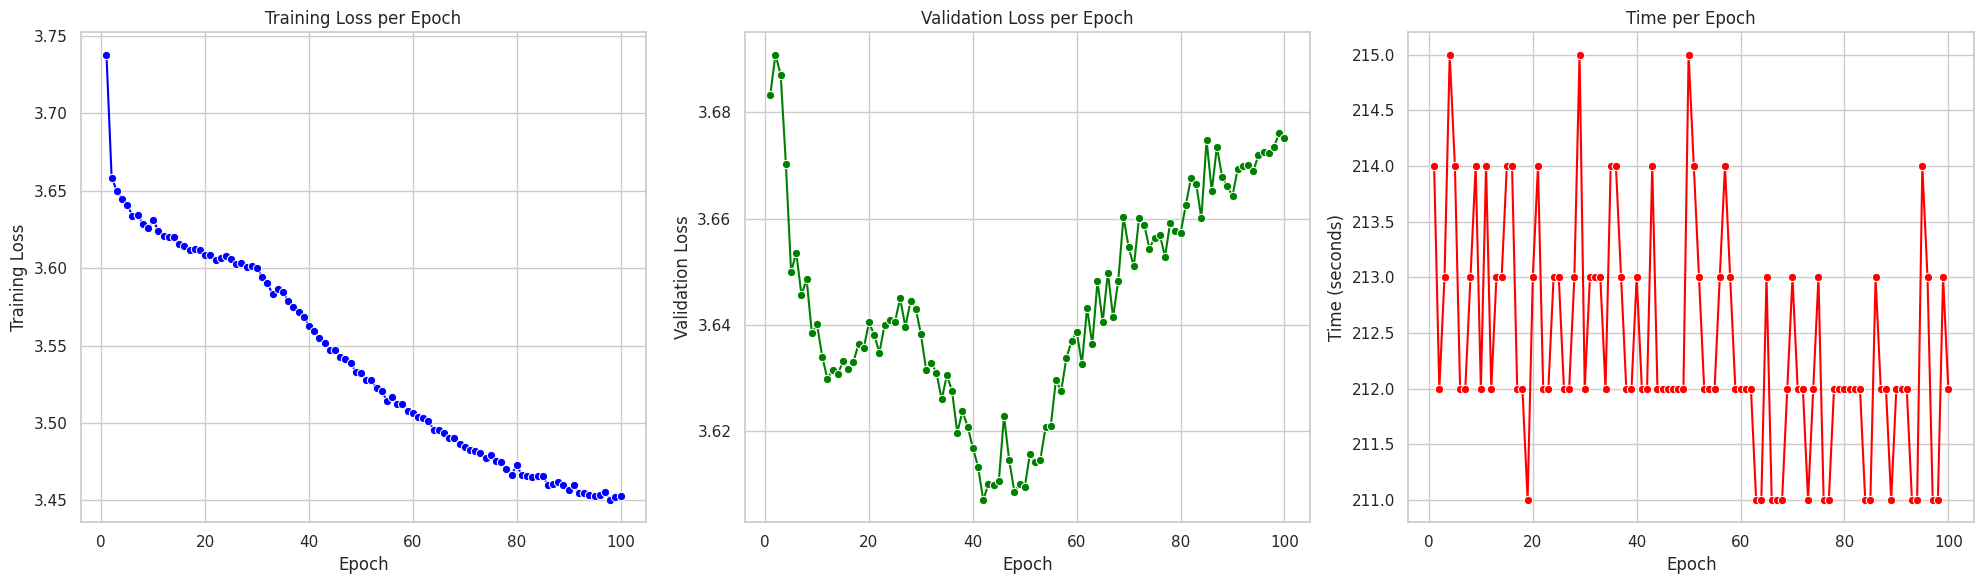

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

training_results = joblib.load(output_path + '/training_results.joblib')

# Set Seaborn style
sns.set(style="whitegrid")


# Extract data
train_losses = [r[0] for r in training_results]
valid_losses = [r[1] for r in training_results]
durations = [r[2] for r in training_results]
epoch_nums = list(range(1, len(training_results) + 1))

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Training Loss
sns.lineplot(x=epoch_nums, y=train_losses, marker='o', ax=axs[0], color='blue')
axs[0].set_title('Training Loss per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')

# Validation Loss
sns.lineplot(x=epoch_nums, y=valid_losses, marker='o', ax=axs[1], color='green')
axs[1].set_title('Validation Loss per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Validation Loss')

# Time per Epoch
sns.lineplot(x=epoch_nums, y=durations, marker='o', ax=axs[2], color='red')
axs[2].set_title('Time per Epoch')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.show()
